In [1]:
import os
from pyson.utils import *
from nltk.metrics.distance import edit_distance
from tensorflow.python import keras
from libmodel import ctc_beam_decode, get_latest_checkpoint
from tf_dataset import get_generator
import sys
import libmodel

Using TensorFlow backend.


In [2]:
def load_model_keras(output_dir, weights_path='weights.h5'):
    from tensorflow.python import keras
    json_file = open(os.path.join(output_dir, 'model_config.json'), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = keras.models.model_from_json(loaded_model_json)
    loaded_model.load_weights(weights_path)#os.path.join(output_dir, weights_name))
    print("Loaded model from disk")
    return loaded_model

def decode(decode_output, int2word):
    str_decode = []
    for _ in decode_output:
        str_decode.append(''.join([int2word[c] for c in _]))
    return str_decode

def test(input_batch, int2word, test_fn):
    model_output = test_fn([input_batch])[0]
    input_length = [model_output.shape[-2]]*model_output.shape[0]
    decode_output = ctc_beam_decode(model_output, input_length)[0]
    str_decode = decode(decode_output, int2word)
    return model_output, model_output, str_decode

data_real_paths = ['/mnt/DATA/DATASET/bprost/free_from_bruce/ff_data_rnd_1/label.json',
               '/mnt/DATA/DATASET/bprost/free_from_bruce/ff_data_rnd_2/label.json',
               '/mnt/DATA/anson/DATASET/poc/ngaythang/label.json',
               '/mnt/DATA/anson/DATASET/special_font/label.json']
data_real_paths  = data_real_paths[2:3]

model_dir = 'frozen_model/ocr_3811/'
text2label = read_json(os.path.join(model_dir, 'text2label.json'))

model_weights_path = get_latest_checkpoint(model_dir)
model_configure = libmodel.cnn_lstm_ctc_model(48, len(text2label))
model_configure['model'].load_weights(model_weights_path)
print('LOAD: ', model_weights_path)
test_fn = keras.backend.function([model_configure['model'].inputs[0]], [model_configure['model'].layers[-5].output])
BATCH_SIZE = 1
int2word = {int(v):k for k, v in text2label.items()}

Found 1 files h5
LOAD:  frozen_model/ocr_3811/chunhat.h5


In [3]:
from tf_dataset import normalize_text
test_generator = get_generator(BATCH_SIZE, \
    db_path=['../../../DATASET/poc/ngaythang/label.json'], text2label=text2label, max_sample=-1, mode='test')

accumulate_accuracy = []
i = 0

Len of samples:  13


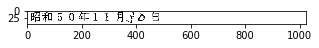

label: 昭和50年11月30日
pred : 昭和50年11月
False


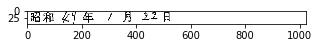

label: 昭和49年1月22日
pred : 昭和49年/月2日
False


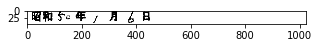

label: 昭和50年1月6日
pred : 昭和o年ﾉ月
False


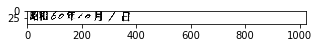

label: 昭和60年10月1日
pred : 昭和6o年月/日
False


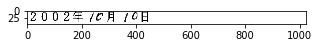

label: 2002年10月10日
pred : 2002年/ロ月/0日
False


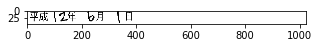

label: 平成12年6月1日
pred : 平成し2年月日
False


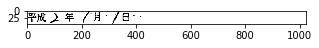

label: 平成2年1月1日
pred : 平成年ノ月・/日-・
False


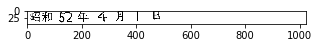

label: 昭和52年4月1日
pred : 昭和52年4月日
False


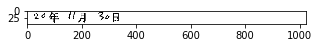

label: 20年11月30日
pred : 2o年(月3日
False


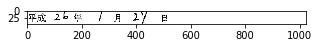

label: 平成26年1月27日
pred : 平成26年/月27日
False


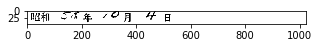

label: 昭和53年10月4日
pred : 昭和年ノ月ケ日
False


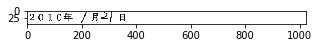

label: 2010年1月21日
pred : 2010年/月⾃I日
False


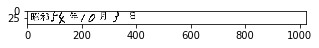

label: 昭和54年10月3日
pred : 昭和6年/車月
False


In [4]:
for a, b in test_generator:
    i += 1
    input_batch = a['the_input']
    str_label = a['source_str']
    model_output, decode_output, str_decode = test(input_batch, int2word, test_fn)
    for img, a,b,c in zip(input_batch,str_label, str_decode, model_output):
        l = len(a)
        a = normalize_text(a).replace(' ','')
        b = normalize_text(b).replace(' ','')
        ed_err = edit_distance(a.replace(' ',''), b.replace(' ', ''))
        acc=1-ed_err/l
        accumulate_accuracy.append(acc)
        if True:#acc < 1:
            show(img[...,0], size=img.shape[1]//30)
            print('label:', a)
            print('pred :',b)
            print(np.array(a)==np.array(b))
    